In [1]:
import time
import scipy.io as scio
import numpy as np
from multiprocessing import Pool
import sys
from copy import copy
from scipy import stats
import matplotlib.pyplot as plt
from MDPD import utils, readers, MDPD

## Utilities

In [21]:
def show_img(arrays, figsize=None):
    "show image(s) in parallel"
    n = len(arrays)
    if figsize:
        plt.figure(figsize=figsize)
    else:
        plt.figure()
    for i in xrange(n):
        plt.subplot(n,1,i+1)
        plt.imshow(arrays[i].reshape((28,28)))
        plt.colorbar()
    plt.show()

## Read Data

In [33]:
# folder = "/media/vzhao/Data/MNIST"
folder = "/Users/vincent/Documents/Research/MDPD/MNIST"
mnist = readers.MNIST_Reader(folder, binarized=True)
train, labels = mnist.train, mnist.labels
_, DIM, _ = train.shape

Extracting /Users/vincent/Documents/Research/MDPD/MNIST/train-images-idx3-ubyte.gz
Extracting /Users/vincent/Documents/Research/MDPD/MNIST/train-labels-idx1-ubyte.gz
Extracting /Users/vincent/Documents/Research/MDPD/MNIST/t10k-images-idx3-ubyte.gz
Extracting /Users/vincent/Documents/Research/MDPD/MNIST/t10k-labels-idx1-ubyte.gz


In [4]:
# data per digit
train_uni = [None] * 10
for dig in xrange(10):
    train_uni[dig] = train[labels==dig,...]
# small sample
train_small = train[:2000,...]
labels_small = labels[:2000]

### Pick a data source

In [5]:
data, labs = train_small, labels_small

## Information residue as in raw data

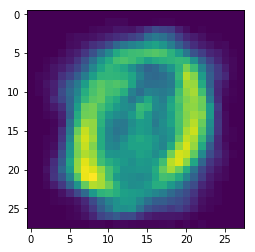

Information residue in raw data
0.00281335565269
CPU times: user 821 ms, sys: 60.7 ms, total: 881 ms
Wall time: 538 ms


In [20]:
%%time
score_origin = utils.Feature_Selection.MI_score(data, rm_diag=True)
sigma_origin = score_origin.sum(axis=1)
show_img([sigma_origin])
print 'Information residue in raw data'
print sigma_origin.mean() / (DIM - 1)

#### Reference G score

In [7]:
percentages = [99,95,90,75,50]
percentiles = [stats.chi2.ppf(x/100.,3) / (2 * data.shape[0]) for x in percentages]
print 'Reference G statistis at {} percentile'.format(percentages)
print percentiles

Reference G statistis at [99, 95, 90, 75, 50] percentile
[0.0028362166825360927, 0.0019536819758127939, 0.0015628471577925807, 0.0010270862339080791, 0.00059149347109383442]


### Mutual Information Residue if ues the labels as the posterior distribution

In [8]:
# label to log_post
def label2logpost(label, ncomp):
    nsample = label.shape[0]
    post = np.zeros((nsample, ncomp))
    for i in xrange(nsample):
        post[i, label[i]] = 1
    return np.log(post)
log_post = label2logpost(labs,labs.max()+1)
utils.log_replace_neginf(log_post)

/Users/vincent/.virtualenvs/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


In [9]:
%%time
score, weighted = MDPD.utils.Feature_Selection.MI_score_conditional(data, log_post, rm_diag=True)
sigma_condition = score.sum(axis=1)
print 'Mutual Information Residue if use the true label as the posterior distribution'
print np.sum(sigma_condition * weighted[np.newaxis, :]) / (DIM * (DIM - 1))

Mutual Information Residue if use the true label as the posterior distribution
0.00351993080509
CPU times: user 12.3 s, sys: 1.31 s, total: 13.6 s
Wall time: 8.06 s


#### [Plot] Mutual Information Residue vs the Residue of the Raw Data

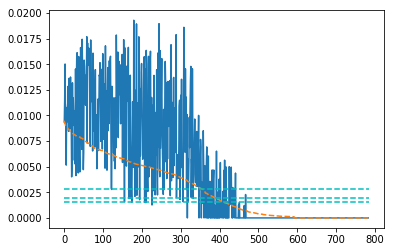

In [10]:
plt.figure()
idx = np.argsort(sigma_origin)[::-1]
for k in [0]:
    plt.plot(sigma_condition[idx,k]/(DIM-1))
plt.plot(sigma_origin[idx] / (DIM-1), '--')
# plot reference G statistics
for foo in percentiles[:3]:
    plt.plot([0, len(score)], [foo, foo], 'c--')
plt.show()

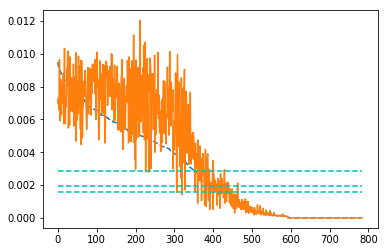

In [11]:
plt.figure()
plt.plot(sigma_origin[idx] / (DIM-1), '--')
plt.plot(np.sum(sigma_condition[idx, ...] * weighted[np.newaxis, :], axis=1) / (DIM-1))
# plot reference G statistics
for foo in percentiles[:3]:
    plt.plot([0, len(score)], [foo, foo], 'c--')
plt.show()

#### [Plot] Mutual information residue conditional on a digit vs Raw MIS

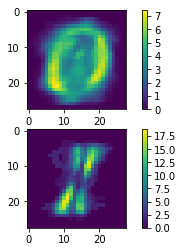

In [22]:
show_img([sigma_origin, sigma_condition[:,1]])

#### Conditional MIS vs Raw MIS

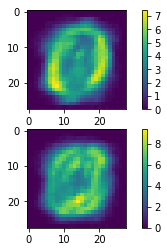

In [23]:
show_img([sigma_origin, np.sum(sigma_condition * weighted[np.newaxis, :], axis=1)])

#### Conclusion

A naive mixture model is not a good generative model of MNIST data set.

## Train a MDPD with the selected features

#### Batch EM

In [25]:
Ntop = 300
model_batch = MDPD.MDPD_standard()
model_batch.fit(data, ncomp=10, init='random', verbose=False, features=Ntop, epoch=100)

2018-04-08 09:50:23,672 : INFO : Training an MDPD with dimension 784, 300 features, sample size 2000, vocab size 2 and the target number of components 10
2018-04-08 09:50:25,242 : INFO : iteration 0; log-likelihood (feature selection) -154.397742; log_likelihood -186.110047
2018-04-08 09:50:26,435 : INFO : iteration 1; log-likelihood (feature selection) -140.649837; log_likelihood -170.384005
2018-04-08 09:50:27,605 : INFO : iteration 2; log-likelihood (feature selection) -136.615672; log_likelihood -165.698106
2018-04-08 09:50:28,770 : INFO : iteration 3; log-likelihood (feature selection) -135.518786; log_likelihood -164.361026
2018-04-08 09:50:29,961 : INFO : iteration 4; log-likelihood (feature selection) -135.021673; log_likelihood -163.815613
2018-04-08 09:50:31,189 : INFO : iteration 5; log-likelihood (feature selection) -134.726213; log_likelihood -163.491550
2018-04-08 09:50:32,441 : INFO : iteration 6; log-likelihood (feature selection) -134.531166; log_likelihood -163.292577

2018-04-08 09:52:04,351 : INFO : iteration 66; log-likelihood (feature selection) -134.253785; log_likelihood -162.955650
2018-04-08 09:52:05,699 : INFO : iteration 67; log-likelihood (feature selection) -134.253741; log_likelihood -162.954281
2018-04-08 09:52:06,988 : INFO : iteration 68; log-likelihood (feature selection) -134.253282; log_likelihood -162.952768
2018-04-08 09:52:08,297 : INFO : iteration 69; log-likelihood (feature selection) -134.251799; log_likelihood -162.950708
2018-04-08 09:52:09,616 : INFO : iteration 70; log-likelihood (feature selection) -134.251424; log_likelihood -162.950212
2018-04-08 09:52:10,951 : INFO : iteration 71; log-likelihood (feature selection) -134.251264; log_likelihood -162.950139
2018-04-08 09:52:12,359 : INFO : iteration 72; log-likelihood (feature selection) -134.251126; log_likelihood -162.950054
2018-04-08 09:52:14,215 : INFO : iteration 73; log-likelihood (feature selection) -134.251028; log_likelihood -162.949861
2018-04-08 09:52:15,524 

In [38]:
log_post = model_batch.log_posterior(data)
score, weights = utils.Feature_Selection.MI_score_conditional(data, log_post, rm_diag=True)
sigma_condition = score.sum(axis=1)
print 'Mutual Information Residue of the model with feature selection'
print np.sum(sigma_condition * weights[np.newaxis, :]) / (DIM * (DIM - 1))

Mutual Information Residue of the model with feature selection
0.00267573398839


#### [plot] mixture component

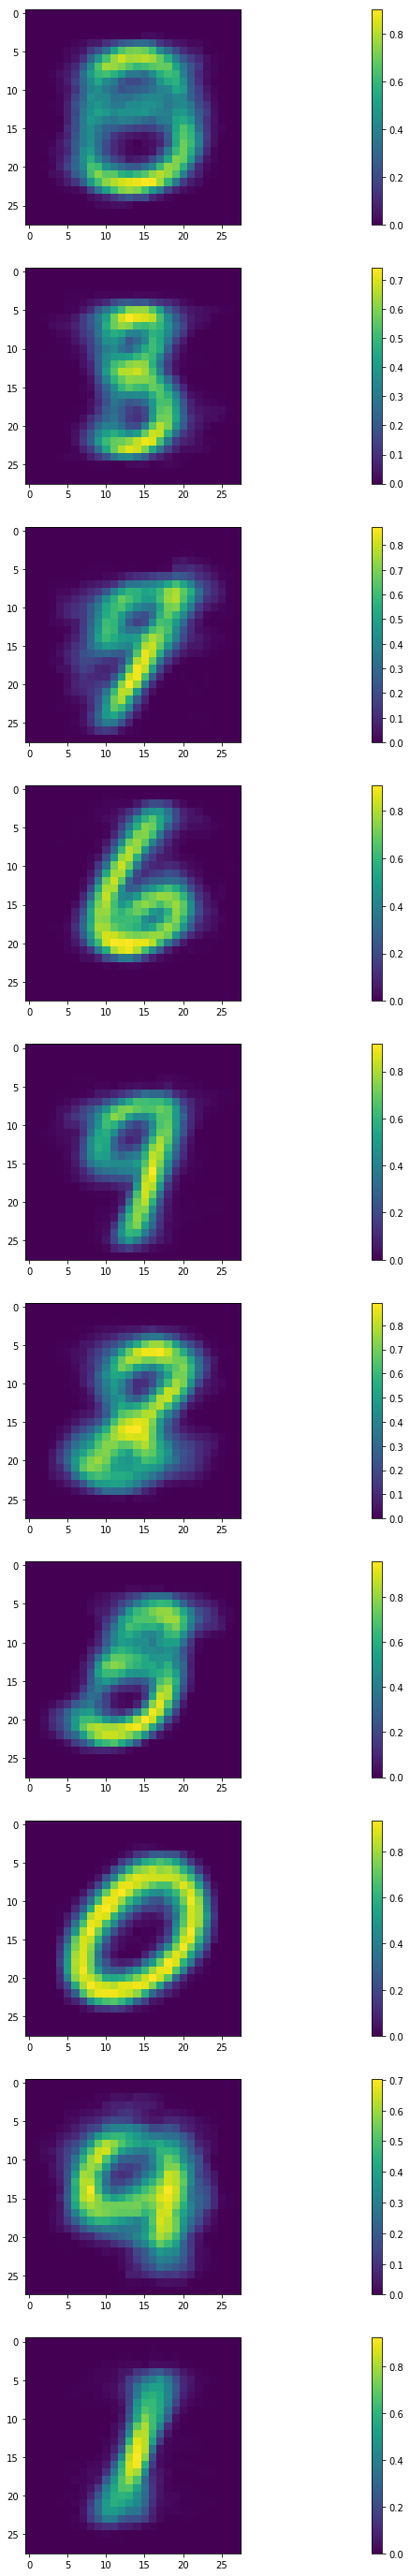

In [28]:
show_img(np.exp([model_batch.logC[:,0,i] for i in xrange(10)]), figsize=(50,50))

#### [Plot] Conditional Information Residue vs the Residue of the Raw Data

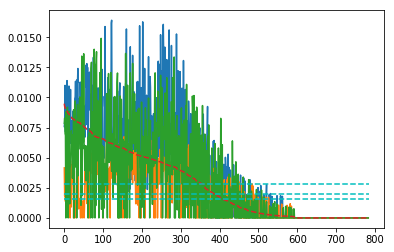

In [42]:
plt.figure()
idx = np.argsort(sigma_origin)[::-1]
for k in xrange(3):
    plt.plot(sigma_condition[idx,k]/(DIM-1))
plt.plot(sigma_origin[idx] / (DIM-1), '--')
# plot reference G statistics
for foo in percentiles[:3]:
    plt.plot([0, len(score)], [foo, foo], 'c--')
plt.show()

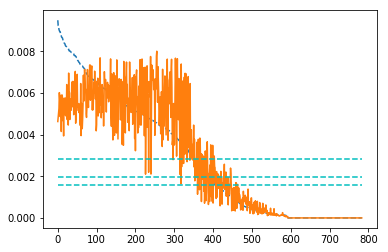

In [43]:
plt.figure()
plt.plot(sigma_origin[idx] / (DIM-1), '--')
plt.plot(np.sum(sigma_condition[idx, ...] * weighted[np.newaxis, :], axis=1) / (DIM-1))
# plot reference G statistics
for foo in percentiles[:3]:
    plt.plot([0, len(score)], [foo, foo], 'c--')
plt.show()

#### [Plot] Mutual information residue conditional on a digit vs Raw MIS

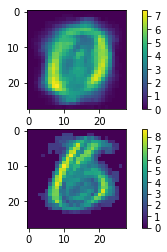

In [48]:
show_img([sigma_origin, sigma_condition[:,3]])

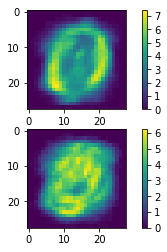

In [50]:
show_img([sigma_origin, np.sum(sigma_condition * weighted[np.newaxis, :], axis=1)])